# SC3000 Project 1 (Balancing a Pole on a Cart)

## Dependency Installation

Please read the `README.md` to install the relevant dependencies from `requirements.txt` using pip before running this notebook.

## Project done by
1. Keith Ang Kee Chun
2. Oh ShuYi

### Project Description
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart. In this project, we will develop a Reinforcement Learning (RL) agent. The trained agent makes the decision to push the cart to the left or right based on the cart position, velocity, and the pole angle, angular velocity.

### Action Space
The action is an *ndarray* with shape (1,) which can take values {0, 1} indicating pushing the cart to the left or right, respectively. Note that the velocity that is reduced or increased by the applied force is not fixed and it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it.

### State Space
We define *observation* as a state (they are used interchangeably here). The observation is an *ndarray* with shape (4,) with the values corresponding to the following positions and velocities:

| **Observation[n]** | **Observation**       | **Min**             | **Max**           |
| ------- | --------------------- | ------------------- | ----------------- |
| **0**   | Cart Position         | \-4.8               | 4.8               |
| **1**   | Cart Velocity         | \-Inf               | Inf               |
| **2**   | Pole Angle            | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
| **3**   | Pole Angular Velocity | \-Inf               | Inf               |

## Condition
The challenge is to balance the pole for **500 states per episode**.

The pole is said to be balanced if:
* Pole Angle is at most ±12°
* Cart Position is at most ±2.4 (center of the cart reaches the edge of the display)

Violation to any of the above two conditions defines an unbalanced pole.

## Solution
We first train the agent using 3 combinations of the states:
1. Cart Position & Cart Velocity
2. Pole Angle & Cart Velocity
3. Pole Angle & Pole Angular Velocity

Then, we looked into the use of 2 other reinforcement learning algorithms to further investigate of the effectiveness of the RL agent:
1. Q-learning
2. Proximity Policy Optimization (PPO)

Lastly, we conclude which policy gives us the best mean reward.


## Importing Dependencies

In [1]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40)
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import time
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from sklearn.model_selection import GridSearchCV
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

## Loading CartPole Environment

In [2]:
env = gym.make("CartPole-v1", render_mode='rgb_array')

print(env.action_space)
print(env.observation_space)

Discrete(2)
Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


/Users/shuyi/Documents/NTU/Y2S2/SC3000/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
observation = env.reset()
print("Initial observations:", observation)

/Users/shuyi/Documents/NTU/Y2S2/SC3000/venv/lib/python3.10/site-packages/pygame/pkgdata.py:27: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/Users/shuyi/Documents/NTU/Y2S2/SC3000/venv/lib/python3.10/site-packages/pkg_resources/__init__.py:2846: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/Users/shuyi/Documents/NTU/Y2S2/SC3000/venv/lib/python3.10/site-packages/pkg_resources/__init__.py:2846: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare

Initial observations: [ 0.03836424 -0.03781579  0.00199883  0.04235401]


In [4]:
gym.version

/Users/shuyi/Documents/NTU/Y2S2/SC3000/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<module 'gym.version' from '/Users/shuyi/Documents/NTU/Y2S2/SC3000/venv/lib/python3.10/site-packages/gym/version.py'>

In [5]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [ 0.03760792 -0.23296635  0.00284591  0.33566692]
Reward for this step: 1.0
Is this round done? False


/Users/shuyi/Documents/NTU/Y2S2/SC3000/venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [6]:
##Function to record Cumulative Rewards per episode

observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward

print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 8.0


# Approach 1: Developing own agents using states:

1. Developing RL agent based on cartpole's position and velocity
2. Developing RL agent based on cartpole's velocity and pole angle
3. Developing RL agent based on cartpole's pole angle and angular velocity


# 1. Developing RL agent based on cartpole's position and velocity


In [7]:
#Uses the cart's position and velocity in making thepolicy
#x -> Pposition of cart such that we can eep the cartpole relatively central (minimise displacement)
#v -> Minimise movement of the cart when marking adjustments

def pos_vel_policy_agent(obs):
    x, v = obs[0:2]  # obs[0]: x-> position of cart, obs[2]: v-> velocity of cart

    #abs value of x < 0.05 -> want to keey it as close to the centre as possible
    if abs(x) < 0.05:
        #if cart is close to the centre, use velocity to balance the pole
        #if it is +ve means it moves right so shift cart left (step 0)
        #if it is -ve means it moves left so shift cart right (step 1)
        return 0 if v>0 else 1
    else:
        #if cart is far from the centre, use cart's position to balance the pole
        #if it is +ve means it is moved towards the right so shift cart left (step 0)
        #if it is -ve means it is moved towards the left so shift cart right (step 1)
        return 0 if x>0 else 1

In [8]:
def test_policy(policy_func, n_scenario = 1000, max_actions = 510, verbose=False):
    final_rewards = []
    for episode in range(n_scenario):
        if verbose and episode % 50 == 0:
            print(episode)
        episode_rewards = 0
        obs = env.reset()  # reset to a random position
        for step in range(max_actions):
            action = policy_func(obs)
            obs, reward, done, info = env.step(action)
            episode_rewards += reward
            if done:
                break
        final_rewards.append(episode_rewards)
    return final_rewards

def plot_policy(final_rewards, policy_name:str=''):
    fig = plt.plot(range(len(final_rewards)), final_rewards)
    plt.grid()
    plt.title(policy_name + " Mean Reward {:.2f}, Std Reward {:.2f}".format(np.mean(final_rewards), np.min(final_rewards)))
    plt.ylabel('Cum Reward')
    plt.xlabel('Iteration')
    plt.ylim(0, max(final_rewards)*1.1)
    return fig

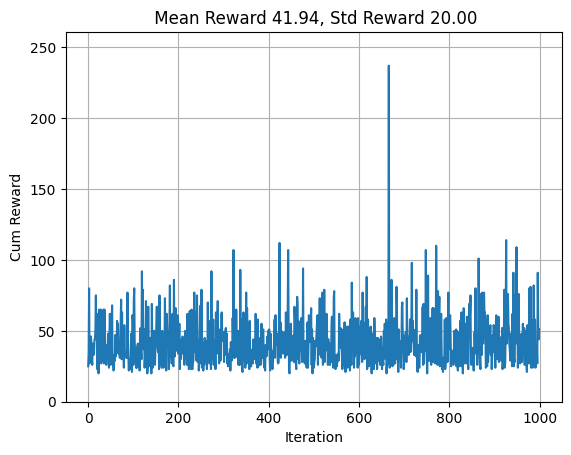

In [9]:
pos_vel_reward = test_policy(pos_vel_policy_agent)
plot_policy(pos_vel_reward)

In [10]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
counter = 0
while True:
    env.render()
    action = pos_vel_policy_agent(observation)
    observation, reward, done, info = env.step(action)
    if done: break
env.close()
show_video()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/subprocess.py:1778: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/Users/shuyi/Documents/NTU/Y2S2/SC3000/venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


# 2. Developing RL agent based on cartpole's velocity and pole angle


In [11]:
def angle_vel_policy_agent(obs):
    v, theta = obs[1:3] # v: velocity of cartpole, theta: pole angle
    if abs(theta) < 0.05:
        return 0 if v>0 else 1 # movs left when cart move to the right, vice versa
    else:
        return 0 if theta<0 else 1 # moves left when pole tilts to the right, vice versa

/Users/shuyi/Documents/NTU/Y2S2/SC3000/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/subprocess.py:1778: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/subprocess.py:1778: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/subprocess.py:1778: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/subprocess.py:1778: RuntimeWarning: os.fork() was called. os.fork() is incompatible with

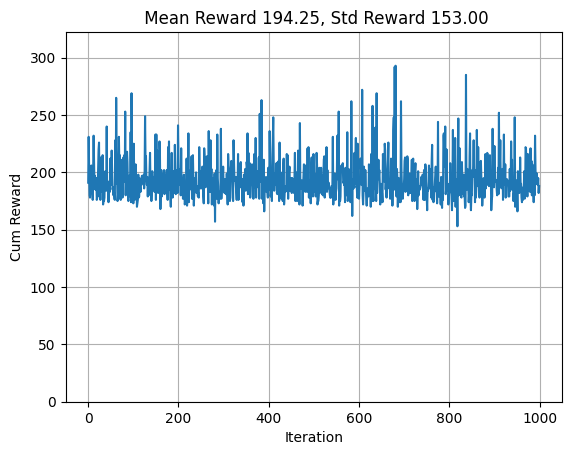

In [12]:
angle_vel_reward = test_policy(angle_vel_policy_agent)
plot_policy(angle_vel_reward)

In [13]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
counter = 0
while True:
    env.render()
    action = angle_vel_policy_agent(observation)
    observation, reward, done, info = env.step(action)
    if done: break
env.close()
show_video()

/Users/shuyi/Documents/NTU/Y2S2/SC3000/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/subprocess.py:1778: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/Users/shuyi/Documents/NTU/Y2S2/SC3000/venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


# 3. Developing RL agent based on cartpole's pole angle and angular velocity

In [14]:
def theta_thetadot_policy_agent(obs):
    theta, thetadot = obs[2:4]
    if abs(theta) < 0.05:
        return 0 if thetadot<0 else 1
    else:
        return 0 if theta<0 else 1

/Users/shuyi/Documents/NTU/Y2S2/SC3000/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/subprocess.py:1778: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/subprocess.py:1778: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/subprocess.py:1778: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/subprocess.py:1778: RuntimeWarning: os.fork() was called. os.fork() is incompatible with

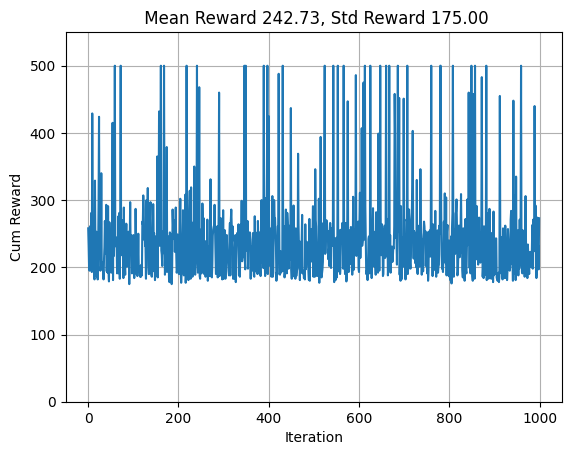

In [15]:
theta_thetadot_reward = test_policy(theta_thetadot_policy_agent)
plot_policy(theta_thetadot_reward)

In [16]:
env = RecordVideo(gym.make("CartPole-v1", render_mode = 'rgb_array'), "./video")
observation = env.reset()
counter = 0
while True:
    env.render()
    action = theta_thetadot_policy_agent(observation)
    observation, reward, done, info = env.step(action)
    if done: break
env.close()
show_video()

/Users/shuyi/Documents/NTU/Y2S2/SC3000/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/subprocess.py:1778: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/Users/shuyi/Documents/NTU/Y2S2/SC3000/venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


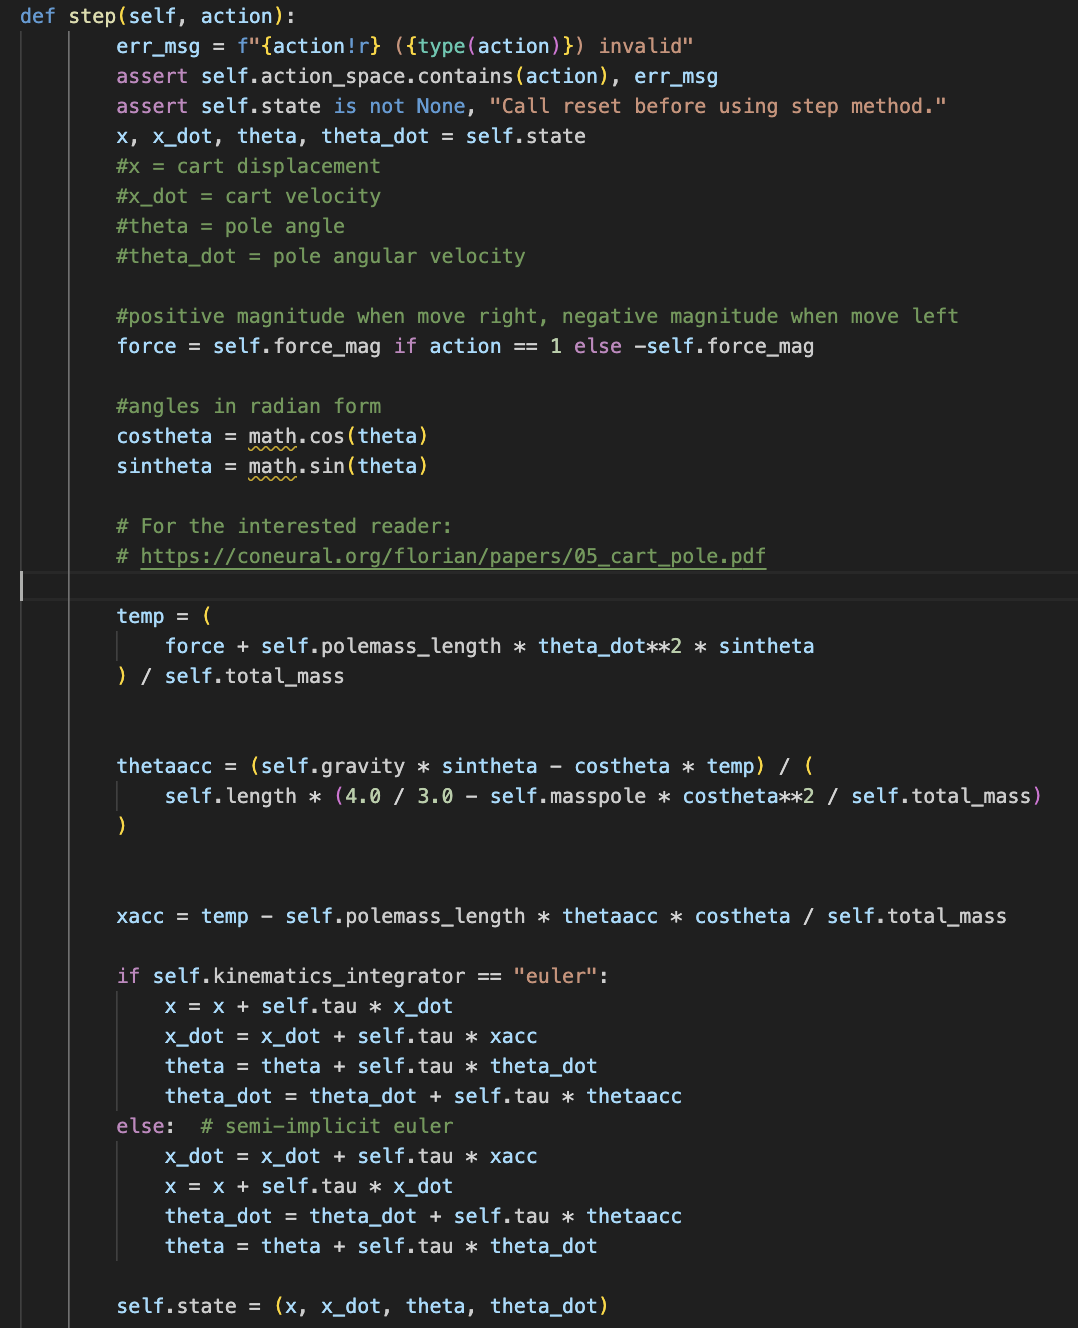

# Code Analysis

1. **temp** calculates the net acceleration of the pole perpendicular to the pole
2. **thetaacc** calculates the angular acceleration of the pole
3. **xacc** calculates the linear acceleration of the pole

As seen from the above, in the calculation of **temp**, **thetaacc** and **xacc**, only the pole angle(theta) and angular velocity(theta_dot) were used to derive the functions. As such, they are the main movers of balancing the cartpole. Whereas the cart's displacement(x) and cart's velocity(x_dot) were mainly used in ensuring that the cart do not go out of the horizontal axis.



 ## Observations
 From our observation of using different combinations of states in the observation space, we found that using Pole Angle and Angular Velocity yield the highest mean reward of 242.73 as compared to the other states. Although our average cumulative reward is higher than the suggested value of 195.


# Conclusion (Approach 1)

From our **1st approach** of creating our own RL agents:
1. Cart Displacement & Cart Velocity (Mean: 41.94)
2. Cart Velocity & Pole Angle (Mean: 194.25)
3. Pole Angle & Pole Angular Velocity (Mean: 242.73)

As seen from above, the 1st & 2nd agent's mean reward is below 195, hence it is not a good agent. Therefore, Pole Angle and Pole Angular Velocity is the 2 vital observation states to be used as a reinforcement agent.

From our observation, we can see that the results obtained from running the 3 different models above correlates with our analysis where Pole Angle and Pole Angular Velocity is the main driving factor in balancing the pole.

We then decided to further investigate using 2 other Reinforcemnet Learning Algorithms:
 1. Q-Learning
 2. Proximity Policy Optimization (PPO)


# Approach 2:

# Q-Learning

To further investigate the effectiveness of the RL agent, we decided to use Q-learning to see if there would be an improvement.

To train the model:

1. Initalise our Q-table to store the Q-values for each state-action pair.
2. Discretize the state values as the cartpole environment is over a range of continous values. We chose the range for the velocities to be between -4 and 4 as upon our own research, when balancing the cartpole, the max speed did not exceed 4 before termination.
3. Set our bin size to 20
4. Randomly initialise the Q-Values using a uniform distribution and use a small epsilon value so as to leverage more on the exploitation of the Q-learning algorithm.

In [17]:
# Defining the CartPole environment
env = gym.make('CartPole-v1')

# Initialising the Q-table with random uniform distributed data
q_table = np.random.uniform(low=-1, high=1, size=([20,20,20,20] + [env.action_space.n]))

# Setting parameters
num_episodes = 60000
epsilon = 0.25
learning_rate = 0.2
discount_factor = 0.995

# Defining the bins for discretizing
def get_bins():
    return [
        np.linspace(-4.8, 4.8, num=20), # Cart displacement
        np.linspace(-4, 4, num=20), # Cart velocity
        np.linspace(-0.418, 0.418, num=20), # Pole angle
        np.linspace(-4, 4, num=20) # Pole angular velocity
    ]

# Function ti discretize state space
def discretize_state(state, bins):
    index = []
    for i in range(len(state)):
        index.append(np.digitize(state[i], bins[i]) - 1)
    return tuple(index)

# Selecting next action based on Q value
def select_action(state, q_table, eps):
    if np.random.uniform() < eps:
        return env.action_space.sample()
    else:
        return np.argmax(q_table[state])

# Updating the Q-table with next state's observations
def update_q_table(q_table, state, action, next_state, reward, lr, gamma):
    old_value = q_table[state + (action,)]
    next_max = np.max(q_table[next_state])
    new_value = (1 - lr) * old_value + lr * (reward + gamma * next_max)
    q_table[state + (action,)] = new_value
    return q_table

# Running 1 episode
def run_episode(env, q_table, eps, bins):
    obs = env.reset()
    done = False
    total_reward = 0
    while not done:
        state = discretize_state(obs, bins)
        action = select_action(state, q_table, eps)
        obs, reward, done, _ = env.step(action)
        next_state = discretize_state(obs, bins)
        q_table = update_q_table(q_table, state, action, next_state, reward, learning_rate, discount_factor)
        total_reward += reward
    return total_reward

# Function to train the agent with 60k episodes
def train_agent(env, q_table, num_episodes, eps, bins):
    rewards = []
    for i in range(num_episodes):
        total_reward = run_episode(env, q_table, eps, bins)
        rewards.append(total_reward)
        if (i + 1) % 100 == 0:
            avg_reward = np.mean(rewards[-100:])
            print(f"Episode {i+1}/{num_episodes}, average reward: {avg_reward:.2f}")
    return q_table, rewards

# Train the agent
q_table_trained, rewards = train_agent(env, q_table, num_episodes, epsilon, get_bins())


/Users/shuyi/Documents/NTU/Y2S2/SC3000/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode 100/60000, average reward: 40.76
Episode 200/60000, average reward: 51.97
Episode 300/60000, average reward: 90.62
Episode 400/60000, average reward: 104.32
Episode 500/60000, average reward: 115.95
Episode 600/60000, average reward: 124.23
Episode 700/60000, average reward: 111.88
Episode 800/60000, average reward: 115.22
Episode 900/60000, average reward: 126.76
Episode 1000/60000, average reward: 107.43
Episode 1100/60000, average reward: 125.48
Episode 1200/60000, average reward: 101.40
Episode 1300/60000, average reward: 108.91
Episode 1400/60000, average reward: 115.80
Episode 1500/60000, average reward: 141.57
Episode 1600/60000, average reward: 141.36
Episode 1700/60000, average reward: 125.86
Episode 1800/60000, average reward: 145.37
Episode 1900/60000, average reward: 120.77
Episode 2000/60000, average reward: 130.95
Episode 2100/60000, average reward: 163.06
Episode 2200/60000, average reward: 124.46
Episode 2300/60000, average reward: 149.39
Episode 2400/60000, ave

In [18]:
avg_reward = np.mean(rewards)
print(f"Average reward over 100 episodes: {avg_reward:.2f}")

Average reward over 100 episodes: 316.91


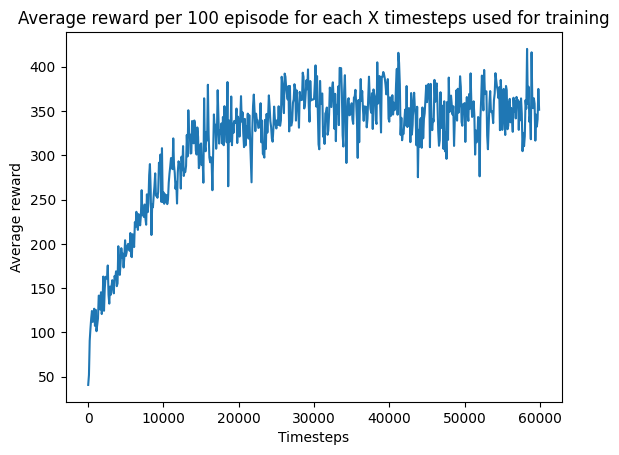

In [19]:
import matplotlib.pyplot as plt

# Calculate the average reward per 100 episodes
avg_rewards = [np.mean(rewards[i:i+100]) for i in range(0, num_episodes, 100)]

# Plot the graph
plt.plot(range(0, num_episodes, 100), avg_rewards)
plt.xlabel('Timesteps')
plt.ylabel('Average reward')
plt.title("Average reward per 100 episode for each X timesteps used for training")
plt.show()

### As the graph approaches 60000 timesteps, we can see a plateau near 350 which indicates that the model has achieved the optimal results. We can then conclude that the training of the model has been completed and is now ready to be tested.

## After training the model, we obtain this trained Q-table to be used to test the effectiviness of the model by running 100 episodes

In [20]:
print(q_table_trained)

[[[[[ 4.66287642e-01  1.77201807e-01]
    [ 1.30239693e-01  8.71556882e-01]
    [ 1.80236047e-01 -2.16506946e-01]
    ...
    [-3.14120046e-01  7.27623359e-01]
    [-2.76105955e-01  5.64587579e-01]
    [ 6.98377962e-01 -1.09342203e-01]]

   [[-1.54674282e-01 -7.72453528e-01]
    [-6.80463158e-01 -6.89360910e-01]
    [ 4.56593962e-02 -6.74908270e-01]
    ...
    [-3.65051912e-01 -9.59749863e-01]
    [-8.54973925e-01 -5.86713916e-01]
    [ 8.73147391e-01  1.08527903e-02]]

   [[ 1.13520677e-01 -3.76629364e-01]
    [ 7.41949801e-01 -8.48745869e-01]
    [-2.32875475e-01 -8.00785385e-01]
    ...
    [-5.55324964e-01 -5.26442082e-01]
    [-9.54558747e-01  8.28166096e-01]
    [ 2.02922135e-01 -7.02701324e-01]]

   ...

   [[ 8.11626145e-01  8.21577951e-01]
    [ 9.25878242e-01 -9.63697253e-01]
    [-1.22939527e-01  3.25511900e-01]
    ...
    [-1.81933357e-01 -1.96673747e-01]
    [ 7.17259727e-01  2.02015712e-01]
    [-6.29234232e-01  2.03063912e-01]]

   [[-4.36560795e-01  5.71619423e-01]
  

# Task 1 (Q-Learning)
Testing the Model

In [21]:
obs = env.reset()
state = discretize_state(obs, get_bins())
action = select_action(state, q_table_trained, 0.25)
print("Observation space is: ", obs)
print("Action taken is: ", action)

Observation space is:  [-0.0105526  -0.0239996   0.01884597  0.00604145]
Action taken is:  1


# Task 2 (Q-Learning)

After training the model, we now test it to run 100 episodes to obtain the average reward.

In [22]:
# Run the agent for 100 episodes
def run_100_eps(env, q_table_trained, num_episodes, eps, bins):
    rewards = []
    for i in range(num_episodes):
        total_reward = run_episode(env, q_table_trained, eps, bins)
        rewards.append(total_reward)
    avg_reward = np.mean(rewards[-100:])
    print(f"Average reward of 100 episodes: {avg_reward:.2f}")
    return q_table_trained, rewards


q_table_test, rewards = run_100_eps(env, q_table_trained, 100, epsilon, get_bins())


Average reward of 100 episodes: 323.32


# Task 3 (Q-Learning)
Rendering 1 episode by Q-learning agent

In [23]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
counter = 0
while True:
    env.render()
    state = discretize_state(obs, get_bins())
    action = select_action(state, q_table_trained, 0.25)
    observation, reward, done, info = env.step(action)
    if done: break
env.close()
show_video()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/subprocess.py:1778: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/Users/shuyi/Documents/NTU/Y2S2/SC3000/venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


# Proximity Policy Optimisation

In PPO, the algorithm combines ideas from A2C (having multiple workers) and TRPO (a trust region to improve the actor). We can do so by using a vectorized environment from the stable baselines3 library and then training the model using 4 environments.

In [24]:
vec_env = make_vec_env("CartPole-v1", n_envs = 4)

model = PPO('MlpPolicy', vec_env, verbose=1, device="auto")

/Users/shuyi/Documents/NTU/Y2S2/SC3000/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Using cpu device


# Training the PPO model

In [25]:
# total_timesteps is the number of env.steps(action) being run during training
model.learn(total_timesteps=30000)

/Users/shuyi/Documents/NTU/Y2S2/SC3000/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.8     |
|    ep_rew_mean     | 22.8     |
| time/              |          |
|    fps             | 18343    |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 37          |
|    ep_rew_mean          | 37          |
| time/                   |             |
|    fps                  | 6657        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.014237245 |
|    clip_fraction        | 0.206       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.682      |
|    explained_variance   | -0.00126    |
|    learning_rate        | 0.

# Task 1 (PPO)
Model testing

In [26]:
observation = vec_env.reset()
action, _ = model.predict(observation)
print("Observation space is: ", observation)
print("Action taken is: ", action)

Observation space is:  [[ 0.01295017 -0.01595252  0.04073469  0.03344797]
 [ 0.01539779 -0.04640897 -0.02098952  0.01235564]
 [-0.03331826 -0.03265249  0.00939276 -0.00939451]
 [-0.02762249 -0.04416401 -0.0165021   0.04479016]]
Action taken is:  [1 1 0 1]


# Task 2 (PPO)
After training the model, we now test it to run 100 episodes to obtain the average reward.

In [27]:
sum_episode_scores = []

for episode in range(1, 101):    ## total 100 episodes
    score = 0
    obs = vec_env.reset()
    done = False
    state = 0

    while True:
        action = model.predict(obs)[0]
        n_state, reward, done, info = vec_env.step(action)
        if (abs(n_state[0][0]) > 2.4 or abs(n_state[0][2]) > 0.209):
            break
        if state == 500:
            break
        obs = n_state
        score += reward
        state += 1

    print('Episode:', episode, ';   Score:', score)
    sum_episode_scores.append(score)


print("Average score is ", sum(sum_episode_scores) / len(sum_episode_scores))

vec_env.close()

Episode: 1 ;   Score: [500. 500. 500. 500.]
Episode: 2 ;   Score: [487. 487. 487. 487.]
Episode: 3 ;   Score: [500. 500. 500. 500.]
Episode: 4 ;   Score: [500. 500. 500. 500.]
Episode: 5 ;   Score: [500. 500. 500. 500.]
Episode: 6 ;   Score: [500. 500. 500. 500.]
Episode: 7 ;   Score: [500. 500. 500. 500.]
Episode: 8 ;   Score: [500. 500. 500. 500.]
Episode: 9 ;   Score: [500. 500. 500. 500.]
Episode: 10 ;   Score: [500. 500. 500. 500.]
Episode: 11 ;   Score: [500. 500. 500. 500.]
Episode: 12 ;   Score: [500. 500. 500. 500.]
Episode: 13 ;   Score: [500. 500. 500. 500.]
Episode: 14 ;   Score: [500. 500. 500. 500.]
Episode: 15 ;   Score: [500. 500. 500. 500.]
Episode: 16 ;   Score: [500. 500. 500. 500.]
Episode: 17 ;   Score: [500. 500. 500. 500.]
Episode: 18 ;   Score: [500. 500. 500. 500.]
Episode: 19 ;   Score: [500. 500. 500. 500.]
Episode: 20 ;   Score: [500. 500. 500. 500.]
Episode: 21 ;   Score: [500. 500. 500. 500.]
Episode: 22 ;   Score: [500. 500. 500. 500.]
Episode: 23 ;   Sco

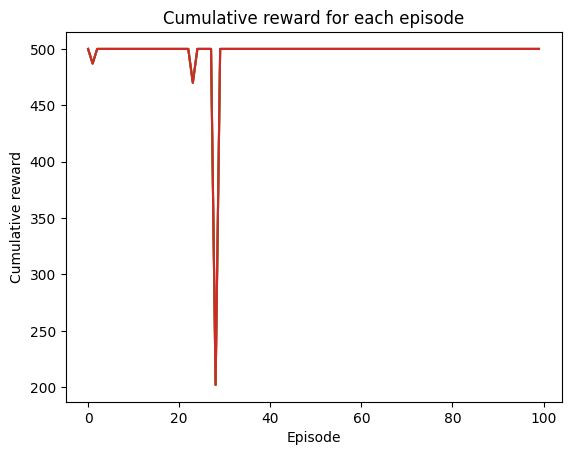

In [28]:
plt.plot(sum_episode_scores)
plt.title("Cumulative reward for each episode")
plt.ylabel("Cumulative reward")
plt.xlabel("Episode")
plt.show()

# Task 3 (PPO)
Rendering 1 episode from PPO agent

In [29]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")

observation = env.reset()
total = 0
state = 0
while True:
    env.render()
    action = model.predict(observation)[0]
    n_state, reward, done, info = env.step(int(action))
    if (abs(n_state[0]) > 2.4 or abs(n_state[2]) > 0.209):
        break
    if state == 500:
        break
    observation = n_state
    total += reward
    state += 1

env.close()
show_video()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/subprocess.py:1778: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/Users/shuyi/Documents/NTU/Y2S2/SC3000/venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


# Conclusion (Approach 2)

Best average rewards:

1. PPO: 496.59
2. Q-Learning: 323.32

By comparing the best average reward of the 2 reinforcement learning algorithms, we can see that PPO performs better than Q-learning. This can be explained as:
1. PPO may work with continuous state spaces, but Q-learning requires that the state space be discretized. The cartpole balance issue features a continuous state space, which is why PPO is more optimal.

2. PPO is a policy optimisation algorithm, which means it optimises the policy itself rather than predicting the best action-value function. This can be beneficial when the optimum policy is complicated or difficult to describe in a tabular format, as is the case of the observation space of the CartPole.